## IALP Roas Forecast

In [187]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.tsatools import detrend
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, seasonal_plot, month_plot
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing, ETSModel, seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from src.utils import *
from prophet import Prophet
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
plt.style.use("ggplot")
plt.rcParams.update({"font.size": 14, "axes.labelweight": "bold", "figure.figsize": (7,5), "lines.linewidth": 2})
from src.plotting import *
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm
import calendar
plt.rcParams['figure.facecolor'] = 'white'



# Prepare data

In [188]:
ialp_raw = pd.read_csv('data/raw/ialp_raw.csv', index_col=0, parse_dates=True)
ialp = ialp_raw.copy()

In [189]:
ialp = ialp.fillna(0)
ialp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10569 entries, 2022-11-01 to 2023-07-01
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          10569 non-null  object 
 1   Month         10569 non-null  object 
 2   Year          10569 non-null  int64  
 3   Channel       10569 non-null  object 
 4   Location      10569 non-null  object 
 5   Format        10569 non-null  object 
 6   Ad_Name       10569 non-null  object 
 7   Full_Ad_Name  10569 non-null  object 
 8   Purchases     10569 non-null  float64
 9   Revenue       10569 non-null  float64
 10  Impressions   10569 non-null  float64
 11  Ad_Clicks     10569 non-null  float64
 12  Spend         10569 non-null  float64
 13  Leads         10569 non-null  float64
dtypes: float64(6), int64(1), object(7)
memory usage: 1.2+ MB


In [190]:
ialp = ialp.sort_values(by='Date')
ialp.tail()

,Date,Month,Year,Channel,Location,Format,Ad_Name,Full_Ad_Name,Purchases,Revenue,Impressions,Ad_Clicks,Spend,Leads
Year_Month,,,,,,,,,,,,,,
2025-07-01,2025-07-30,July,2025,Google Search,CAN,Text,Generic,WR _ 2024 _ Google Search _ Canada _ Both Devi...,1.0,1132.200,241.0,36.0,122.784699,1.0
2025-07-01,2025-07-31,July,2025,Google Search,Interested,Text,Victoria Generic,WR _ 2024 _ Google Search _ Interested _ Deskt...,0.0,0.000,148.0,21.0,105.789649,0.0
2025-07-01,2025-07-31,July,2025,Travel Ads,0,0,Travel Ads,0,16.0,6700.117,2725.0,127.0,347.450980,0.0
2025-07-01,2025-07-31,July,2025,Performance Max Audience,CAN,Dynamic,BC-AB,WR _ 2024 _ Performance Max Audience _ Canada ...,1.0,557.100,12319.0,247.0,498.880844,1.0
2025-07-01,2025-07-31,July,2025,Google Search,CAN,Text,Generic,WR _ 2024 _ Google Search _ Canada _ Both Devi...,0.0,0.000,512.0,73.0,236.196306,0.0


In [191]:
ialp['ROAS'] = (ialp['Revenue'] / ialp['Spend']).fillna(0)
ialp['ROAS'] = ialp['ROAS'].replace(np.inf, 0)
ialp.head()

,Date,Month,Year,Channel,Location,Format,Ad_Name,Full_Ad_Name,Purchases,Revenue,Impressions,Ad_Clicks,Spend,Leads,ROAS
Year_Month,,,,,,,,,,,,,,,
2022-01-01,2022-01-01,January,2022,Google Search,CAN,Text,BC DSA,WR _ 2023 _ Google Search _ Canada _ Both Devi...,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000
2022-01-01,2022-01-01,January,2022,Google Search,Interested,Text,Victoria Generic,WR _ 2023 _ Google Search _ Interested _ Mobil...,3.0,1170.0,184.0,40.0,31.026667,0.0,37.709497
2022-01-01,2022-01-01,January,2022,Google Search,CAN,Text,AB/BC Generic,WR _ 2024 _ Google Search _ Canada _ Both Devi...,0.0,0.0,5.0,0.0,0.000000,0.0,0.000000
2022-01-01,2022-01-01,January,2022,Google Search,Interested,Text,Victoria Generic,WR _ 2024 _ Google Search _ Interested _ Deskt...,0.0,0.0,116.0,16.0,51.740000,0.0,0.000000
2022-01-01,2022-01-01,January,2022,Facebook Lookalike,BC,Static,Hideaway _ Ad 1,2021 _ Facebook Lookalike _ BC _ Both Device _...,2.0,898.8,0.0,0.0,0.000000,0.0,0.000000


In [192]:
roas = ialp['ROAS'].copy()
roas = roas.groupby(ialp.index).mean().to_frame()

In [193]:
roas.head()

,ROAS
Year_Month,
2022-01-01,10.695889
2022-02-01,14.940937
2022-03-01,21.185851
2022-04-01,14.886175
2022-05-01,11.899257


In [194]:
#df = pd.read_excel('data/external/IALP_Monthly_2019_2021.xlsx', index_col=0, parse_dates=True)
#df = df.asfreq('MS')
#df = df.loc[df.index >= "2021-01-01", ["ROAS"]].copy()
#df.head()

In [195]:
#roas = pd.concat([roas, df], axis=0).sort_index()
roas.to_csv('data/processed/roas(since2022).csv')

## STL Decompose

In [196]:
# Additive
stl_add = STL(roas, seasonal=13, period=12).fit()
resid_add = stl_add.resid

# Multiplicative(log-transform)
stl_mul = STL(np.log(roas), seasonal=13, period=12).fit()
resid_mul = np.exp(stl_mul.resid)  # back-transform

# Compare standard deviations of residuals
print("Additive resid std:", resid_add.std())
print("Multiplicative resid std:", resid_mul.std())


Additive resid std: 2.133280865024147
Multiplicative resid std: 0.1343198779537585


In [197]:
# Decompose the data with STL 
#model = STL(roas, period=12, seasonal=13).fit()
#with mpl.rc_context():
#    mpl.rc("figure", figsize=(7, 12))
#    model.plot()

In [198]:
#seasonal = model.seasonal.groupby(model.seasonal.index.month).mean()
#seasonal.plot.line(xlabel="Time", ylabel="IALP ROAS seasonal variation", marker="o")
#plt.xticks(range(1, 13), calendar.month_name[1:], rotation='vertical');

## Use Multi-STL

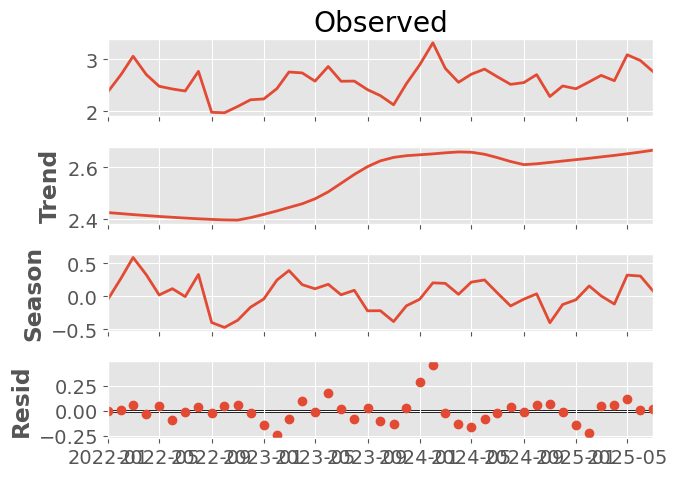

In [199]:
stl_mul = STL(np.log(roas), period=12, seasonal=13).fit()
resid_mul = np.exp(stl_mul.resid) 
stl_mul.plot();

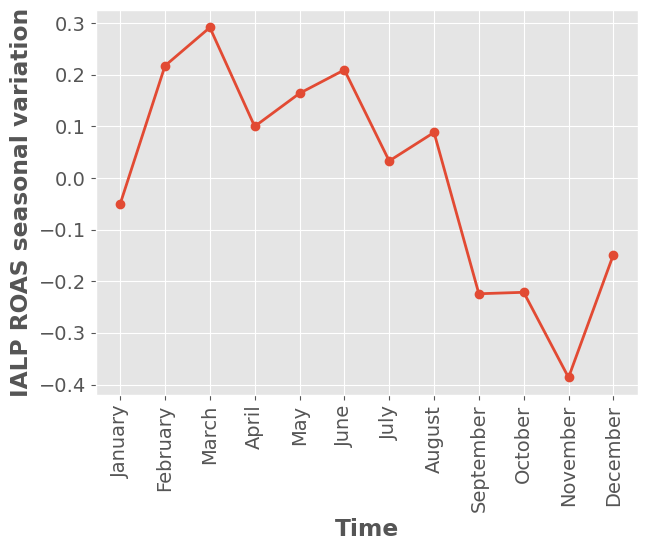

In [200]:
seasonal = stl_mul.seasonal.groupby(stl_mul.seasonal.index.month).mean()
seasonal.plot.line(xlabel="Time", ylabel="IALP ROAS seasonal variation", marker="o")
plt.xticks(range(1, 13), calendar.month_name[1:], rotation='vertical');

<Axes: xlabel='Time', ylabel='IALP ROAS seasonal variation'>

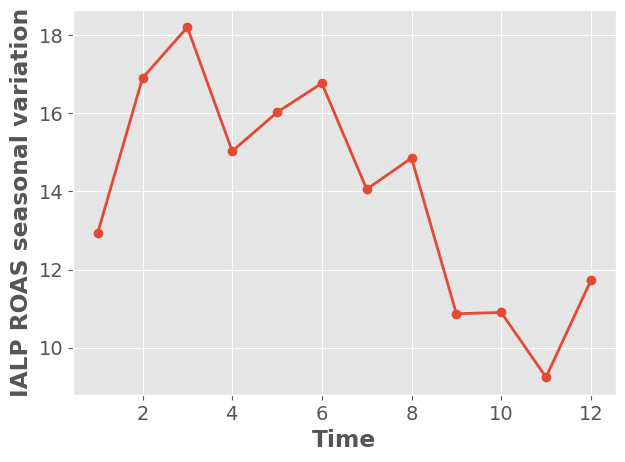

In [201]:
baseline_roas = 13.6
seasonal_factor = np.exp(seasonal)
monthly_roas = baseline_roas * seasonal_factor
monthly_roas.plot.line(xlabel="Time", ylabel="IALP ROAS seasonal variation", marker="o")

In [202]:
# Normalize seasonal factor and apply to average ROAS
#seasonal_factor = np.exp(seasonal)
#seasonal_factor = seasonal_factor / seasonal_factor.mean()
#monthly_roas = 16.6 * seasonal_factor
#monthly_roas.plot.line(xlabel="Time", ylabel="IALP ROAS seasonal variation", marker="o")

In [203]:
monthly_roas.to_csv('../IALP_analysis/outputs/predictions/roas_mul_seasonal.csv')